# **Final project:** EM and Gibbs sampling
Kai Gong, UChicago, Spring 2023


## Instructions

The purpose of this project is to apply the ideas:
* Bayesian mixture models
* conditional conjugacy
* Gibbs sampling
* EM


## Zero-inflated Poisson Mixture Model

The following generative process defines the model we will be working with:
$$
\begin{align}
\boldsymbol{\pi} &\sim \textrm{Dir}(\boldsymbol{\alpha})\\
\omega_{k, d} &\stackrel{\textrm{iid}}{\sim}\textrm{Beta}(a_0, b_0) \\
\lambda_{k, d} &\stackrel{\textrm{iid}}{\sim}\textrm{Gamma}(e_0, f_0) \\
z_i &\stackrel{\textrm{iid}}{\sim} \textrm{Cat}(\boldsymbol{\pi})\\
b_{i,d} &\stackrel{\textrm{ind.}}{\sim} \textrm{Bernoulli}(\omega_{z_i, d}) \\
x_{i,d} &\stackrel{\textrm{ind.}}{\sim} 
\begin{cases}
\delta_0 &\textrm{ if } b_{i,d}=0 \\
\textrm{Pois}(\lambda_{z_i, d}) &\textrm{ if } b_{i,d}=1 \\
\end{cases} 
\end{align}$$

* Each observation is a $D$-dimensional count vector $\boldsymbol{x}_i = (x_{i,1},\dots,x_{i,D}) \in \mathbb{N}_0^D$.

* Each $x_{i,d}$ is associated with a latent Bernoulli variable $b_{i,d}$.  When $b_{i,d}=1$, $x_{i,d}$ is sampled from a Poisson.  When $b_{i,d}=0$, $x_{i,d}=0$ deterministically.

* Each observation is assigned to one of $K$ mixture components $z_i \in \{1,\dots, K\}$.

* We will often use the following transformation of $z_i$
$$
\zeta_{ik} \triangleq \delta(z_i = k),\,\,\boldsymbol{\zeta}_i = (\zeta_{i1},\dots,\zeta_{iK})
$$
* An equivalent way to sample the cluster assignment is:
$$
\boldsymbol{\zeta}_i \sim \textrm{Multinomial}(1, \boldsymbol{\pi})
$$

* Each mixture component $k$ is associated with two $D$-dimensional parameter vectors, $\boldsymbol{\omega}_k$ and $\boldsymbol{\lambda}_k$. 

* The vector $\boldsymbol{\omega}_k = (\omega_{k,1},\dots, \omega_{k,D})$ gives the probabilities for the zero-inflated part of the likelihood; each one $\omega_{k,d} \in (0,1)$ is Beta distributed.

* The vector $\boldsymbol{\lambda}_k = (\lambda_{k,1},\dots, \lambda_{k,D})$ gives the rates for the Poisson part of the likelihood; each one $\lambda_{k,d} > 0 $ is Gamma distributed.

* The weights $\boldsymbol{\pi} \in \Delta_K$ give the prior probability of each component. 

The complete data likelihood of observed $X$ and latent variables $Z$ and $B$ is:
$$
P(X, B, Z \mid \Lambda, \Omega, \boldsymbol{\pi}) = \left[\prod_{i=1}^n P(z_i \mid \boldsymbol{\pi}) \prod_{d=1}^D P(x_{id} \mid b_{id}, \lambda_{z_i, d}) \, P(b_{id} \mid \omega_{z_i, d})\right]$$

The prior over parameters $\Lambda, \Omega, \boldsymbol{\pi}$ is:
$$
P(\Lambda, \Omega, \boldsymbol{\pi}) = P(\boldsymbol{\pi} \mid \boldsymbol{\alpha}) \left[\prod_{k=1}^K \prod_{d=1}^D P(\omega_{k,d} \mid a_0, b_0) \, P(\lambda_{k,d} \mid e_0, f_0)\right]
$$

The following code implements "forward sampling" from the above model. It samples the latent variables from the prior, then the observed variables from the likelihood. The function takes in a dictionary called `hyperparams`, which contains values for the hyperparameters (e.g., $e_0$), and returns two dictionaries---`state` and `data`---which contains values of the latent and observed variables, respectively.

In [ ]:
import numpy as np
import numpy.random as rn
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import scipy.special as sp
from tqdm.notebook import tqdm
from copy import deepcopy


def forward_sample(n, D, hyperparams):
    """Generate latent and observed variables from the zero-inflated Poisson mixture model.

    Args:
        n (int): number of data points
        D (int): number of dimensions of each data point
        hyperparams (dict): hyperparameters of the model

    Returns:
        state (dict): dictionary of latent variables
        data (dict): dictionary of observed variables
    """
    a0, b0, e0, f0, alpha_K = [hyperparams[key] for key in ['a0', 'b0', 'e0', 'f0', 'alpha_K']]
    K = alpha_K.size
    
    # sample mixture weights
    pi_K = rn.dirichlet(alpha_K)
    
    # sample component parameters
    omega_KD = rn.beta(a0, b0, size=(K, D))
    lambd_KD = rn.gamma(e0, 1.0/f0, size=(K, D))
    
    # sample assignments (this samples the zeta_ik form of z_i)
    zeta_NK = rn.multinomial(1, pi_K, size=n)
    
    # sample zero-inflated portion
    B_ND = rn.binomial(1, zeta_NK @ omega_KD)
    
    # sample data
    X_ND = B_ND * rn.poisson(zeta_NK @ lambd_KD)

    # define all latent variables as the "state"
    state = {'pi_K': pi_K,
             'omega_KD': omega_KD,
             'lambd_KD': lambd_KD,
             'zeta_NK': zeta_NK,
             'B_ND': B_ND}
    
    # define all observed variables as the "data"
    data = {'X_ND': X_ND}

    return state, data


# Example of usage

K = 3
hyperparams = {'a0': 2.0, 
               'b0': 2.0, 
               'e0': 2.0, 
               'f0': 0.1,
               'alpha_K': np.ones(K)}

state, data = forward_sample(n=1000, D=10, hyperparams=hyperparams)

##1: Complete conditionals

Derive the following complete conditionals.

#### 1a) $$P(\boldsymbol{\pi} \mid -) =\textrm{Dir}(\boldsymbol{\alpha + \sum^n_{i=1}\zeta_i})$$

___

#### 1b) $$P(\omega_{k,d} \mid -) =\textrm{Beta}\left(a_0 + \sum_{i=1}^n \zeta_{ik} b_{i,d}, b_0 + \sum_{i=1}^n \zeta_{ik} (1 - b_{i,d})\right)$$

___

#### 1c) $$P(\lambda_{k,d} \mid -) =\textrm{Gamma}(e_0+\sum_{i=1}^n \zeta_{ik} b_{i,d} x_{i,d}, f_0+ \sum_{i=1}^n \zeta_{ik} b_{i,d}) $$

___


##2: Complete conditionals

Here we will implement the complete conditionals for the parameters $\boldsymbol{\pi}, \Omega, \Lambda$. We have implemented the complete conditional for $\boldsymbol{\pi}$ as an example; you will implement those for $\Omega$ and $\Lambda$.

In [ ]:
# def update_pi_K(state, data, hyperparams):
#     """Update the mixture weights \pi_k. 
    
#     This samples pi_K from its complete conditional.
#     It then overwrites the current value of pi_K in the state dictionary.
    
#     Args:
#         state (dict): dictionary of latent variables
#         data (dict): dictionary of observed variables
#         hyperparams (dict): hyperparameters of the model
    
#     Returns:
#         state (dict): dictionary of latent variables
#     """
#     zeta_NK = state['zeta_NK']
#     alpha_K = hyperparams['alpha_K']
#     state['pi_K'] = rn.dirichlet(alpha_K + zeta_NK.sum(axis=0))
#     return state

# def update_omega_KD(state, data, hyperparams):
#     """Update the component parameters \omega_{k,d}.

#     This samples omega_KD from its complete conditional.
#     It then overwrites the current value of omega_KD in the state dictionary.

#     Args:
#         state (dict): dictionary of latent variables
#         data (dict): dictionary of observed variables
#         hyperparams (dict): hyperparameters of the model
    
#     Returns:
#         state (dict): dictionary of latent variables
#     """
#     zeta_NK = state['zeta_NK']
#     B_ND = state['B_ND']
#     a0, b0 = hyperparams['a0'], hyperparams['b0']
#     K, D = state['omega_KD'].shape

#     for k in range(K):
#         for d in range(D):
#             state['omega_KD'][k, d] = rn.beta(a0 + (zeta_NK[:, k] * B_ND[:, d]).sum(),
#                           b0 + (zeta_NK[:, k] * (1 - B_ND[:, d])).sum())
#     return state

# def update_lambd_KD(state, data, hyperparams):
#     """Update the component parameters \lambda_{k,d}.

#     This samples lambd_KD from its complete conditional.
#     It then overwrites the current value of lambd_KD in the state dictionary.

#     Args:
#         state (dict): dictionary of latent variables
#         data (dict): dictionary of observed variables
#         hyperparams (dict): hyperparameters of the model
    
#     Returns:
#         state (dict): dictionary of latent variables
#     """
#     zeta_NK = state['zeta_NK']
#     B_ND = state['B_ND']
#     X_ND = data['X_ND']
#     e0, f0 = hyperparams['e0'], hyperparams['f0']
#     K, D = state['lambd_KD'].shape

#     for k in range(K):
#         for d in range(D):
#             state['lambd_KD'][k, d] = rn.gamma(e0 + (zeta_NK[:, k] * B_ND[:, d] * X_ND[:, d]).sum(),
#                                                1.0 / (f0 + (zeta_NK[:, k] * B_ND[:, d]).sum()))
#     return state


def update_pi_K(state, data, hyperparams):
    state['pi_K'] = rn.dirichlet(hyperparams['alpha_K'] + state['zeta_NK'].sum(axis=0))
    return state

def update_omega_KD(state, data, hyperparams):
    a0, b0 = hyperparams['a0'], hyperparams['b0']
    state['omega_KD'] = rn.beta(a0 + (state['zeta_NK'].T @ state['B_ND']),
                                 b0 + (state['zeta_NK'].T @ (1 - state['B_ND'])))
    return state

def update_lambd_KD(state, data, hyperparams):
    e0, f0 = hyperparams['e0'], hyperparams['f0']
    state['lambd_KD'] = rn.gamma(e0 + (state['zeta_NK'].T @ (state['B_ND'] * data['X_ND'])),
                                  1.0 / (f0 + (state['zeta_NK'].T @ state['B_ND'])))
    return state

##3: Complete conditionals

Derive the following complete conditionals.

#### 3a) $$P(b_{i,d}=1 \mid -) =\frac{\omega_{z_i,d}Pois(x_{i,d}\mid λ_{z_i,d})} {\omega_{z_i,d}Pois(x_{i,d}\mid λ_{z_i,d}) + (1-\omega_{z_i,d})δ_0(x_{i,d})}$$

___

#### 3b) $$P(z_i=k \mid -) =\frac{\pi_k \prod_{d=1}^D \left[ \textrm{Pois}(x_{i,d} \mid \lambda_{k, d})  \omega_{k, d} \right]^{b_{i,d}} \left[\delta_0(x_{i,d}) (1-\omega_{k, d})\right]^{1-b_{i,d}}}{\sum_{k'=1}^K \pi_{k'} \prod_{d=1}^D \left[ \textrm{Pois}(x_{i,d} \mid \lambda_{k', d})  \omega_{k', d} \right]^{b_{i,d}} \left[\delta_0(x_{i,d}) (1-\omega_{k', d})\right]^{1-b_{i,d}}}$$
___

#### 3c) $$P(z_i=k \mid -\backslash_{\boldsymbol{b}_i}) = \frac{\pi_k \prod_{d=1}^D \left[ \textrm{Pois}(x_{i,d} \mid \lambda_{k, d})  \omega_{k, d} + \delta_0(x_{i,d}) (1-\omega_{k, d})\right]}{\sum_{k'=1}^K \pi_{k'} \prod_{d=1}^D \left[ \textrm{Pois}(x_{i,d} \mid \lambda_{k', d})  \omega_{k', d} +\delta_0(x_{i,d}) (1-\omega_{k', d})\right]}$$

This questions derive a "collapsed" complete conditional, where all $b_{i,d}$ variables have been "collapsed" (i.e., marginalized) out.

First derive the marginal likelihood $P(x_{i,d} \mid z_i, \Omega, \Lambda)$ with $b_i$ marginalized out, and then derive the complete conditional of $z_i$ based on that.
___




##4: Complete conditionals

Here we will implement the complete conditional for $B$ and the "collapsed" conditional for $Z$.



In [ ]:
# def update_B_ND(state, data, hyperparams):

#     X_ND = data['X_ND']
#     omega_KD = state['omega_KD']
#     zeta_NK = state['zeta_NK']
#     lambd_KD = state['lambd_KD']
#     n, D = X_ND.shape
#     K = zeta_NK.shape[1]

#     log_P_ND = np.zeros((n, D))

#     for i in range(n):
#         for d in range(D):
#             zi = np.argmax(zeta_NK[i])
#             if X_ND[i, d] == 0:
#                 log_P_ND[i, d] = np.log(omega_KD[zi, d]) + st.poisson.logpmf(X_ND[i, d], lambd_KD[zi, d]) - np.logaddexp(np.log(omega_KD[zi, d]) + st.poisson.logpmf(X_ND[i, d], lambd_KD[zi, d]), np.log1p(-omega_KD[zi, d]))
#             else:
#                 log_P_ND[i, d] = 0

#     P_ND = np.exp(log_P_ND)

#     state['B_ND'] = rn.binomial(1, P_ND)
#     return state

# def update_zeta_NK(state, data, hyperparams):
    
#     X_ND = data['X_ND']
#     omega_KD = state['omega_KD']
#     zeta_NK = state['zeta_NK']
#     lambd_KD = state['lambd_KD']
#     n, D = X_ND.shape
#     K = zeta_NK.shape[1]
#     pi_K = state['pi_K']
#     log_P_NK = np.zeros((n, K))

#     for i in range(n):
#       for k in range(K):
#         log_prod = np.log(pi_K[k])
#         for d in range(D):
#           if X_ND[i, d] == 0:
#             log_prod += np.logaddexp(np.log(omega_KD[k, d]) + st.poisson.logpmf(X_ND[i, d], lambd_KD[k, d]), np.log1p(-omega_KD[k, d]))
#           else:
#             log_prod += np.log(omega_KD[k, d]) + st.poisson.logpmf(X_ND[i, d], lambd_KD[k, d])
#         log_P_NK[i,k] = log_prod
#     for i in range(n):
#       log_P_NK[i] -= sp.logsumexp(log_P_NK[i])
#     P_NK = np.exp(log_P_NK)

#     for i in range(n):
#         state['zeta_NK'][i] = rn.multinomial(1, P_NK[i])
#     return state

def update_B_ND(state, data, hyperparams):
    X_ND = data['X_ND']
    omega_KD = state['omega_KD']
    zeta_NK = state['zeta_NK']
    lambd_KD = state['lambd_KD']
    n, D = X_ND.shape
    K = zeta_NK.shape[1]

    z_indices = np.argmax(zeta_NK, axis=1)
    omega_iD = omega_KD[z_indices]
    lambd_iD = lambd_KD[z_indices]
    log_P_ND_b1 = np.log(omega_iD) + st.poisson.logpmf(X_ND, lambd_iD)
    log_P_ND_b0 = np.where(X_ND == 0, np.log1p(-omega_iD), -np.inf)
    log_P_ND = log_P_ND_b1 - sp.logsumexp(np.stack([log_P_ND_b0, log_P_ND_b1]), axis=0)
    P_ND = np.exp(log_P_ND)
    state['B_ND'] = rn.binomial(1, P_ND)
    return state

def update_zeta_NK(state, data, hyperparams):
    X_ND = data['X_ND']
    omega_KD = state['omega_KD']
    zeta_NK = state['zeta_NK']
    lambd_KD = state['lambd_KD']
    n, D = X_ND.shape
    K = zeta_NK.shape[1]
    pi_K = state['pi_K']

    log_pmf = st.poisson.logpmf(X_ND[:, np.newaxis, :], lambd_KD[np.newaxis, :, :])
    log_P_NK = np.log(pi_K) + np.sum(np.where(X_ND[:, np.newaxis, :] == 0,
                                              np.logaddexp(np.log(omega_KD) + log_pmf, np.log1p(-omega_KD)),
                                              np.log(omega_KD) + log_pmf), axis=2)
    log_P_NK -= sp.logsumexp(log_P_NK, axis=1, keepdims=True)
    P_NK = np.exp(log_P_NK)

    for i in range(n):
        state['zeta_NK'][i] = rn.multinomial(1, P_NK[i])

    return state

### Defining the Gibbs transition operator


In [ ]:
def get_gibbs_transition(data, hyperparams):
    """Returns a function that performs a single Gibbs transition
    
    Args:
        data (dict): dictionary containing the observed variables
        hyperparams (dict): dictionary containing the hyperparameters
    
    Returns:
        function: function that performs a single Gibbs transition
    """
    
    update_funcs = {
        'pi_K': update_pi_K,
        'omega_KD': update_omega_KD,
        'lambd_KD': update_lambd_KD,
        'zeta_NK': update_zeta_NK,
        'B_ND': update_B_ND
    }

    def gibbs_transition(state):
        for var in update_funcs.keys():
            state = update_funcs[var](state, data, hyperparams)
        return state

    return gibbs_transition


def gibbs(data, hyperparams, n_samples=250, n_burnin=100, n_thin=5):
    """Gibbs sampler for the Zero-Inflated Poisson Mixture Model

    Args:
        data (dict): dictionary containing the observed variables
        hyperparams (dict): dictionary containing the hyperparameters
        n_samples (int, optional): number of posterior samples to collect. 
        n_burnin (int, optional): number of burn-in samples.
        n_thin (int, optional): thinning parameter. Only collect every n_thin samples.
    
    Returns:
        posterior_samples (list): list of posterior samples, each sample is a state dictionary
    """
    # get the transition operator
    gibbs_transition = get_gibbs_transition(data, hyperparams)

    # initialize the state from the prior
    n, D = data['X_ND'].shape
    state, _ = forward_sample(n, D, hyperparams)
    
    # burn-in samples
    for _ in tqdm(range(n_burnin)):
        state = gibbs_transition(state)
    
    posterior_samples = []
    for s in tqdm(range(n_samples * n_thin)):
        state = gibbs_transition(state)

        # only collect every n_thin samples
        if s % n_thin == 0:
            # make sure to deepcopy so the code does not modify the collected states
            posterior_samples.append(deepcopy(state)) 
    
    return posterior_samples      

### Testing / debugging code

To debug the code, use a **Geweke test**.The Geweke test generates a set of **forward samples** and set of **backward samples**.

The set of forward samples and backward samples should be equal in distribution if Gibbs transition operator is correctly implemented.

We will use a visual test to test for equality in distribution. To do this we will need to implement `pp_plot`. 

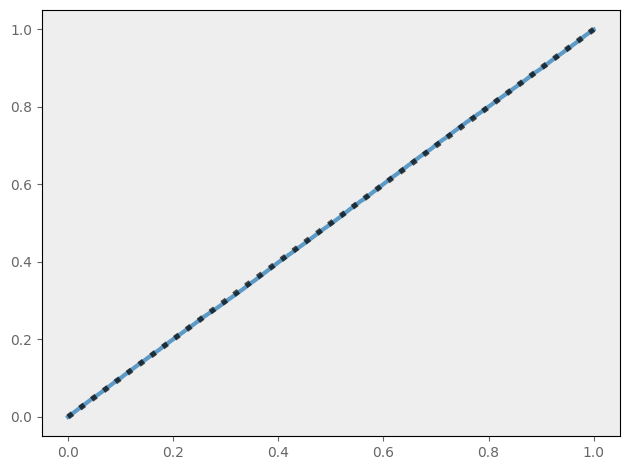

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


gray = (102/255.0, 102/255.0, 102/255.0, 1.0)
light_gray = (238/255.0, 238/255.0, 238/255.0, 1.0)

# sns.set_style({'font.family': 'Abel'})
sns.set_style({'axes.facecolor': light_gray})
sns.set_style({'xtick.color': gray})
sns.set_style({'text.color': gray})
sns.set_style({'ytick.color': gray})
sns.set_style({'axes.grid': False})


def _cdf(data):
    """
    Returns the empirical CDF (a function) for the specified data.

    Arguments:

    data -- data from which to compute the CDF
    """

    tmp = np.empty_like(data)
    tmp[:] = data
    tmp.sort()

    def f(x):
        return np.searchsorted(tmp, x, 'right') / float(len(tmp))

    return f


def pp_plot(a, b, t=None, plot_dir=None, show=True):
    """
    Generates a P-P plot.
    """
    if not show:
        if t is None:  # plot name is required for out path
            raise NotImplementedError
        if plot_dir is None:
            plot_dir = 'pp_plots'
        if not os.path.exists(plot_dir):
            os.makedirs(plot_dir)
        plot_path = os.path.join(plot_dir, '%s.png' % t)

    if isinstance(a, dict):
        assert isinstance(b, dict) and a.keys() == b.keys()
        for n, (k, v) in enumerate(a.items()):
            plt.subplot(221 + n)
            x = np.sort(np.asarray(v))
            if len(x) > 10000:
                step = int(len(x) / 5000)
                x = x[::step]
            plt.plot(_cdf(v)(x), _cdf(b[k])(x), lw=3, alpha=0.7)
            plt.plot([0, 1], [0, 1], ':', c='k', lw=4, alpha=0.7)
            if t is not None:
                plt.title(t + ' (' + k + ')')
            plt.tight_layout()
        if show:
            plt.show()
        else:
            plt.savefig(plot_path)
        plt.clf()
    else:
        x = np.sort(np.asarray(a))
        if len(x) > 10000:
            step = int(len(x) / 5000)
            x = x[::step]
        plt.plot(_cdf(a)(x), _cdf(b)(x), lw=3, alpha=0.7)
        plt.plot([0, 1], [0, 1], ':', c='k', lw=4, alpha=0.7)
        if t is not None:
            plt.title(t)
        plt.tight_layout()
        if show:
            plt.show()
        else:
            plt.savefig(plot_path)
        plt.clf()


def test(num_samples=100000):
    """
    Test code.
    """

    a = np.random.normal(20.0, 5.0, num_samples)
    b = np.random.normal(20.0, 5.0, num_samples)
    pp_plot(a, b)


if __name__ == '__main__':
    test()

In [ ]:
def generate_data(state):
    zeta_NK, lambd_KD, B_ND = state['zeta_NK'], state['lambd_KD'], state['B_ND']
    X_ND = B_ND * rn.poisson(zeta_NK @ lambd_KD)
    data = {'X_ND': X_ND}
    return data

def geweke_test(n, D, hyperparams, n_samples=1000, n_burnin=100, n_thin=5):
    """Geweke test for the Zero-Inflated Poisson Mixture Model
    
    Args:
        n (int): number of data points
        D (int): dimensionality of the data
        hyperparams (dict): dictionary containing the hyperparameters
        n_samples (int, optional): number of forward and backward samples to collect.
        n_burnin (int, optional): number of burn-in samples.
        n_thin (int, optional): thinning parameter. Only collect every n_thin samples.
    
    Returns:
        forward_samples (list): list of forward samples, each sample is a state dictionary
        backward_samples (list): list of backward samples, each sample is a state dictionary
    
    References:
        [1] Grosse & Duvenaud (2014) "Testing MCMC Code": https://arxiv.org/pdf/1412.5218.pdf
        [2] Geweke (2004) "Getting it right...": https://www.jstor.org/stable/27590449
    """

    # sample forward from the prior and likelihood
    forward_samples = []
    for _ in tqdm(range(n_samples)):
        state, data = forward_sample(n, D, hyperparams)
        #  we will only collect the states
        forward_samples.append(deepcopy(state))  

    # sample backward using the Gibbs transition operator
    backward_samples = []

    # first initialize with a forward sample of the state, data
    state, data = forward_sample(n, D, hyperparams)

    # the transition operator is defined by data and hyperparams
    gibbs_transition = get_gibbs_transition(data, hyperparams)
    
    # burn-in samples
    for _ in tqdm(range(n_burnin)):
        # perform a single Gibbs transition
        state = gibbs_transition(state)
        # generate data from the new state
        data = generate_data(state)
        # condition on the new data by redefining the transition operator
        gibbs_transition = get_gibbs_transition(data, hyperparams)
    
    for s in tqdm(range(n_samples * n_thin)):
        # perform a single Gibbs transition
        state = gibbs_transition(state)
        # generate data from the new state
        data = generate_data(state)
        # condition on the new data by redefining the transition operator
        gibbs_transition = get_gibbs_transition(data, hyperparams)
        # collect every n_thin sample
        if s % n_thin == 0:
            # we will only collect the states
            backward_samples.append(deepcopy(state))
    
    return forward_samples, backward_samples

##5: Geweke test
The PP-plot looks like straight lines along the diagonal. This indicates the correcteness of all three implementations.


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

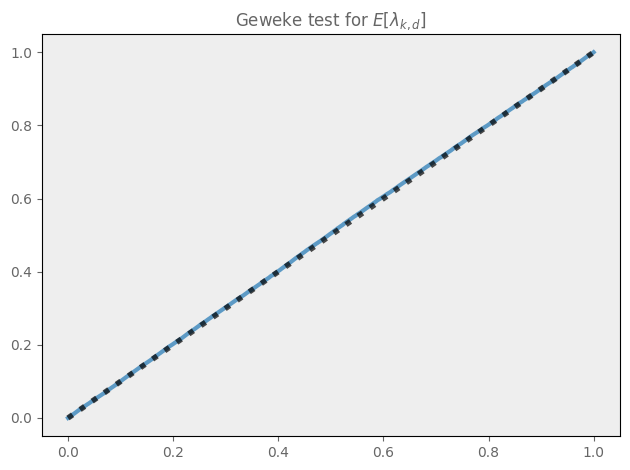

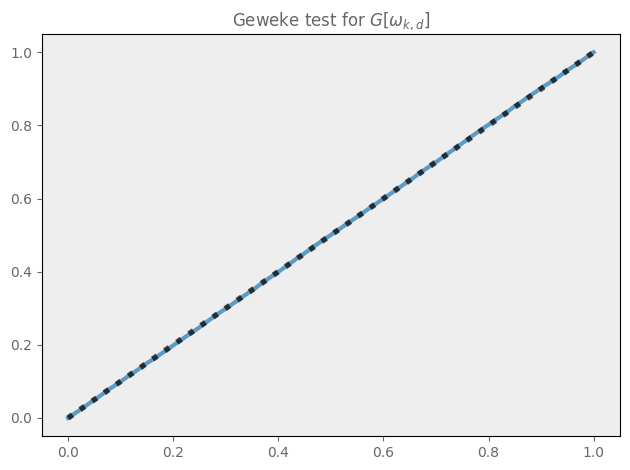

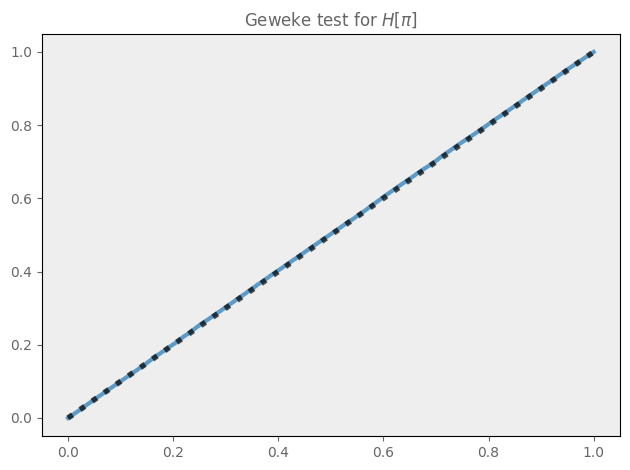

<Figure size 640x480 with 0 Axes>

In [ ]:
# You can/should use small n, D, K for the purposes of testing to speed up the code
# Theoretically, your code should pass the Geweke test for any setting of hyperparams.
n = 10
D = 4
K = 3
hyperparams = {'a0': 2.0,
               'b0': 2.0,
               'e0': 2.0,
               'f0': 1.0,
               'alpha_K': np.ones(2)}

forward_samples, backward_samples = geweke_test(n=n, 
                                                D=D, 
                                                hyperparams=hyperparams, 
                                                n_samples=100000, 
                                                n_burnin=10000, 
                                                n_thin=5)

# Compare the arithmetic mean of the lambd_KD parameters across samples
arr1 = [state['lambd_KD'].mean() for state in forward_samples]
arr2 = [state['lambd_KD'].mean() for state in backward_samples]
pp_plot(arr1, arr2, 'Geweke test for $E[\lambda_{k,d}]$')

# Compare the geometric mean of the omega_KD parameters across samples
arr1 = [np.exp(np.mean(np.log(state['omega_KD']))) for state in forward_samples]
arr2 = [np.exp(np.mean(np.log(state['omega_KD']))) for state in backward_samples]
pp_plot(arr1, arr2, 'Geweke test for $G[\omega_{k,d}]$')

# Compare the entropy of the pi vector across samples
arr1 = [st.entropy(state['pi_K']) for state in forward_samples]
arr2 = [st.entropy(state['pi_K']) for state in backward_samples]
pp_plot(arr1, arr2, 'Geweke test for $H[\pi]$')

## Loading "real" (synthetic) data

The project will run Gibbs sampler on data manipulated by forward sampling.

First load in the `data` and `hyperparams` dictionaries using `pickle`.

In [ ]:
import pickle

with open('data.pkl', 'rb') as f:
    data = pickle.load(f)

with open('hyperparams.pkl', 'rb') as f:
    hyperparams = pickle.load(f)

The data is synthetic and has been generated by the model.

We have re-ordered the rows of the data matrix $X$ so that observations that were part of the same (true) cluster are adjacent. (In a realistic setting, we would not know the true clusters and would not be able to order the matrix in this way.) By doing this, we can explore similarity between observations by glimpsing  "block structure" in the $n \times n$ matrix $X^\top X$, as below:


<Axes: >

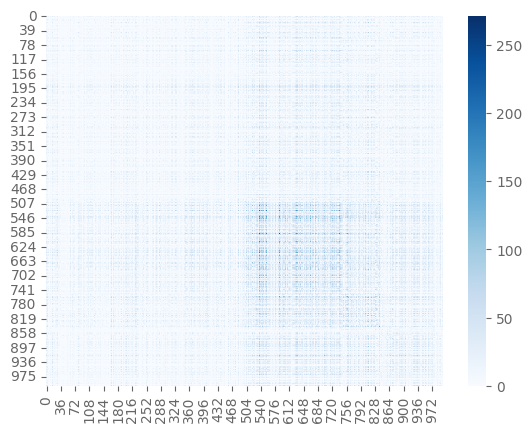

In [ ]:
X_ND = data['X_ND']
sns.heatmap(X_ND @ X_ND.T, cmap='Blues')

##6: Results on "real" data
As you can see above, the block structure is very faint. We can instead use our model to get a clearer picture of the similarity between observations.

The following code does Gibbs sampling on the data with the provided hyperparameters.

Gibbs sampling will return $S=5,000$ posterior samples of the latent variables $\{\Lambda^s, \Omega^s, \boldsymbol{\pi}^s, Z^s, B^s\}_{s=1}^S$.

Once completed, you will use those samples to compute the following similarity matrix $A \in (0,1)^{n \times n}$, where an entry $A_{ij}$ is an estimate of the following posterior expectation:

$$
A_{ij} = \mathbb{E}\left[z_i = z_j \mid X\right] = \sum_{z_i=1}^K \sum_{z_j=1}^K P(z_i, z_j \mid X)\, \delta(z_i = z_j)
$$
where $P(z_i, z_j \mid X)$ is the posterior over $z_i$ and $z_j$ conditional on the data $X$ (and hyperparameters). The output of the code is a heatmap of $A$.

In [ ]:
n_samples = 5000
n_burnin = 1000
n_thin = 5

posterior_samples = gibbs(data=data, 
                          hyperparams=hyperparams, 
                          n_samples=n_samples, 
                          n_burnin=n_burnin,
                          n_thin=n_thin)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

<Axes: >

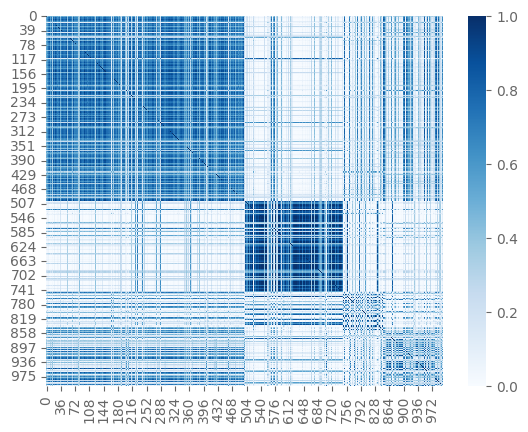

In [ ]:
def compute_similarity_matrix_gibbs(posterior_samples):
    """Compute the posterior expectation of the similarity matrix between posterior samples
    
    Args:
        posterior_samples (list): list of posterior samples, each sample is a state dictionary
    
    Returns:
        similarity_matrix (np.ndarray): similarity matrix between posterior samples
    """

    n = posterior_samples[0]['zeta_NK'].shape[0]
    n_samples = len(posterior_samples)
    
    A_NN = np.zeros((n, n))

    for sample in tqdm(posterior_samples):
        zeta_NK = sample['zeta_NK']
        cluster_assignments = np.argmax(zeta_NK, axis=1)
        # for i in range(n):
        #     for j in range(n):
        #         if cluster_assignments[i] == cluster_assignments[j]:
        #             A_NN[i, j] += 1
        same_cluster_matrix = cluster_assignments[:, None] == cluster_assignments
        A_NN += same_cluster_matrix

    A_NN /= n_samples

    return A_NN

A_NN = compute_similarity_matrix_gibbs(posterior_samples)
sns.heatmap(A_NN, cmap='Blues')

## Part II: The EM algorithm

In this part, we will implement the EM algorithm to do MAP estimation for the parameters $\boldsymbol{\pi}, \Omega, \Lambda$.

The EM algorithm will also provide us with expectations or "beliefs" for the latent variables $Z$ and $B$.

In the E-step, the EM algorithm computes the "beliefs". We will help you by telling you that you will need to compute the following posterior expectations:
\begin{align}
\mathbb{E}_Q[\zeta_{i,k}] \equiv P(z_i =k \mid \boldsymbol{x}_{i}, \boldsymbol{\pi}, \Omega, \Lambda, X) \textrm{ for } i, k
\end{align}

\begin{align}
\mathbb{E}_Q[b_{i,d}]_k \equiv P(b_{i,d}=1 \mid x_{i,d}, z_i=k, \boldsymbol{\pi}, \Omega, \Lambda) \textrm{ for } i, d, k
\end{align}

In the M-step, the EM algorithm maximizes the ELBO with respect to the parameters $\boldsymbol{\pi}, \Omega, \Lambda$. This means
\begin{align}
\boldsymbol{\pi} &\leftarrow \argmax_{\boldsymbol{\pi}} \mathbb{E}_Q\left[\log P(\boldsymbol{\pi} \mid Z, B, X)\right] \\
\Omega &\leftarrow \argmax_{\Omega} \mathbb{E}_Q\left[\log P(\Omega \mid Z, B, X)\right] \\
\Lambda &\leftarrow \argmax_{\Lambda} \mathbb{E}_Q\left[\log P(\Lambda \mid Z, B, X)\right]
\end{align}



##7: E-step

Derive and provide forms for the beliefs.

___

$$
\mathbb{E}_Q[\zeta_{i,k}] \equiv P(z_i =k \mid \boldsymbol{x}_{i}, \boldsymbol{\pi}, \Omega, \Lambda, X) \textrm{ for } i, k
$$
___
$$= \frac{\pi_k \prod_{d=1}^D \left[ \textrm{Pois}(x_{i,d} \mid \lambda_{k, d})  \omega_{k, d} + \delta_0(x_{i,d}) (1-\omega_{k, d})\right]}{\sum_{k'=1}^K \pi_{k'} \prod_{d=1}^D \left[ \textrm{Pois}(x_{i,d} \mid \lambda_{k', d})  \omega_{k', d} +\delta_0(x_{i,d}) (1-\omega_{k', d})\right]}$$
___
$$
\mathbb{E}_Q[b_{i,d}]_k \equiv P(b_{i,d}=1 \mid x_{i,d}, z_i=k, \boldsymbol{\pi}, \Omega, \Lambda) \textrm{ for } i, d, k
$$
___
$$=\frac{\omega_{k,d}Pois(x_{i,d}\mid λ_{k,d})} {\omega_{k,d}Pois(x_{i,d}\mid λ_{k,d}) + (1-\omega_{k,d})δ_0(x_{i,d})}$$


___

##8: M-step

Derive and provide forms for the M-step updates.
___

$$\pi_k = \frac{\sum^N_{i=1} E_Q[\zeta_{i,k}]+\alpha_k-1}{N+\sum^K_{j=1}(\alpha_j-1)} $$
___
$$\omega_{k,d} = \frac{\sum^N_{i=1} E_Q[\zeta_{i,k}]E_Q[b_{i,d}]_k+ \alpha_0-1}{\sum^N_{i=1} E_Q[\zeta_{i,k}]+ \alpha_0+\beta_0-2}$$
___
$$\lambda_{k,d} = \frac{\sum^N_{i=1} E_Q[\zeta_{i,k}]x_{i,d}+ e_0-1}{\sum^N_{i=1} E_Q[\zeta_{i,k}]E_Q[b_{i,d}]_k+ f_0}$$
___

##9: Implement EM

In [ ]:

def e_step(data, belief_state, params_state, hyperparams):
    """Perform the E-step of the EM algorithm for the Zero-Inflated Poisson Mixture Model
    
    Args:
        data (dict): dictionary of observed variables
        belief_state (dict): dictionary of expectations of latent variables
        params_state (dict): dictionary of parameters
        hyperparams (dict): dictionary of hyperparameters
    
    Returns:
        belief_state (dict): updated dictionary of expectations of latent variables
    """    
    X_ND = data['X_ND']
    pi_K = params_state['pi_K']
    omega_KD = params_state['omega_KD']
    lambd_KD = params_state['lambd_KD']
    n, D = X_ND.shape
    K = pi_K.size

    #
    # Your code here
    #
    log_pmf = st.poisson.logpmf(X_ND[:, np.newaxis, :], lambd_KD[np.newaxis, :, :])
    log_P_NK = np.log(pi_K) + np.sum(np.where(X_ND[:, np.newaxis, :] == 0,
                                              np.logaddexp(np.log(omega_KD) + log_pmf, np.log1p(-omega_KD)),
                                              np.log(omega_KD) + log_pmf), axis=2)
    log_P_NK -= sp.logsumexp(log_P_NK, axis=1, keepdims=True)
    Ezeta_NK = np.exp(log_P_NK)

    KND = []
    for k in range(K):
      z_indices = k
      omega_iD = omega_KD[z_indices]
      lambd_iD = lambd_KD[z_indices]
      log_P_ND_b1 = np.log(omega_iD) + st.poisson.logpmf(X_ND, lambd_iD)
      log_P_ND_b0 = np.where(X_ND == 0, np.log1p(-omega_iD), -np.inf)
      log_P_ND = log_P_ND_b1 - sp.logsumexp(np.stack([log_P_ND_b0, log_P_ND_b1]), axis=0)
      P_ND = np.exp(log_P_ND)
      KND.append(P_ND)
    Eb_NKD = np.array(KND).transpose(1,0,2)

    belief_state['Ezeta_NK'] = Ezeta_NK
    belief_state['Eb_NKD'] = Eb_NKD
    assert Ezeta_NK.shape == (n, K)
    assert Eb_NKD.shape == (n, K, D)
    return belief_state


def m_step(data, belief_state, params_state, hyperparams):
    """Perform the M-step of the EM algorithm for the Zero-Inflated Poisson Mixture Model

    Args:
        data (dict): dictionary of observed variables
        belief_state (dict): dictionary of expectations of latent variables
        params_state (dict): dictionary of parameters
        hyperparams (dict): dictionary of hyperparameters

    Returns:
        params_state (dict): updated dictionary of parameters
    """
    a0, b0, e0, f0, alpha_K = [hyperparams[key] for key in ['a0', 'b0', 'e0', 'f0', 'alpha_K']]
    Ezeta_NK, Eb_NKD = belief_state['Ezeta_NK'], belief_state['Eb_NKD']
    X_ND = data['X_ND']
    
    #
    # Your code here
    #

    params_state['pi_K'] = (Ezeta_NK.sum(axis=0) + alpha_K - 1) / (Ezeta_NK.shape[0]+ alpha_K.sum() - len(alpha_K))
    params_state['omega_KD'] = (np.sum(Ezeta_NK[:, :, None] * Eb_NKD, axis=0)+a0-1) / (np.sum(Ezeta_NK, axis=0)[:, None]+a0+b0-2)
    params_state['lambd_KD'] = (np.sum(Ezeta_NK[:, :, None] * X_ND[:, None, :], axis=0)+e0-1) / (np.sum(Ezeta_NK[:, :, None] * Eb_NKD, axis=0)+f0)
    return params_state


def initialize_em(data, hyperparams):
    """Initialize the parameters and beliefs for the EM algorithm for the Zero-Inflated Poisson Mixture Model
    
    Args:
        data (dict): dictionary of observed variables
        hyperparams (dict): dictionary of hyperparameters
    
    Returns:
        params_state (dict): dictionary of parameters
        belief_state (dict): dictionary of expectations of latent variables
    """
    rn.seed(617)
    n, D = data['X_ND'].shape
    K = hyperparams['alpha_K'].size

    params_state = {}
    params_state['pi_K'] = np.ones(K) / K
    params_state['omega_KD'] = rn.beta(5, 5, size=(K, D))
    params_state['lambd_KD'] = rn.gamma(1, 10, size=(K, D))

    belief_state = {}
    belief_state['Ezeta_NK'] = np.ones((n, K)) / K
    belief_state['Eb_NKD'] = np.ones((n, K, D)) * 0.75
    return params_state, belief_state


def em(data, hyperparams, max_iter=100, tol=1e-8):
    """Run the EM algorithm for the Zero-Inflated Poisson Mixture Model

    Args:
        data (dict): dictionary of observed variables
        hyperparams (dict): dictionary of hyperparameters
        max_iter (int): maximum number of iterations
        tol (float): tolerance for convergence
    """
    params_state, belief_state = initialize_em(data, hyperparams)

    prev_params_state = deepcopy(params_state)
    for _ in tqdm(range(max_iter)):
        belief_state = e_step(data, belief_state, params_state, hyperparams)
        params_state = m_step(data, belief_state, params_state, hyperparams)

        # assess convergence (this can also be done by implementing the ELBO)
        if np.abs(prev_params_state['lambd_KD'] - params_state['lambd_KD']).max() < tol:
            break

        prev_params_state = deepcopy(params_state)
    
    return params_state, belief_state


## 10: Results on "real" data

Run the EM algorithm on the data and provided hyperparameters from the first part.

As before, the code also implement a way to visualize the similarity between observations, this time using the beliefs.

An entry in the similarity matrix should equal the following expectation:

$$
A_{ij} = \mathbb{E}\left[z_i = z_j \mid X, \boldsymbol{\pi}^*, \Omega^*, \Lambda^* \right]
$$

where $\boldsymbol{\pi}^*, \Omega^*, \Lambda^*$ are the MAP estimates of the parameters.


In [ ]:
params_state, belief_state = em(data, hyperparams, max_iter=100, tol=1e-8)

  0%|          | 0/100 [00:00<?, ?it/s]

<Axes: >

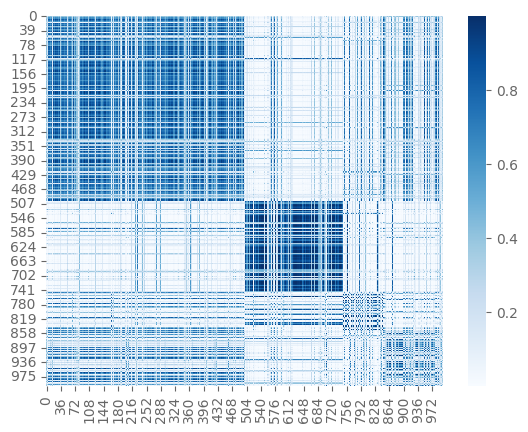

In [ ]:
def compute_similarity_matrix_em(params_state, belief_state):
    """Compute the expectation of the similarity matrix given MAP estimates of parameters
    
    Args:
        posterior_samples (list): list of posterior samples, each sample is a state dictionary
    
    Returns:
        similarity_matrix (np.ndarray): similarity matrix between posterior samples
    """

    Ezeta_NK = belief_state['Ezeta_NK']
    A_NN = np.dot(Ezeta_NK, Ezeta_NK.T)

    return A_NN

A_NN = compute_similarity_matrix_em(params_state, belief_state)
sns.heatmap(A_NN, cmap='Blues')